# Machine Learning in Python - Project 2

Due Friday, April 12th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [1]:
!pip install xgboost

In [2]:
#install
!pip install imblearn

In [3]:
# Add any additional libraries or submodules below
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

# Plotting defaults
plt.rcParams['figure.figsize'] = (30,30)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
# from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# About Tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [4]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. FreddiMac company or similar company). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [5]:
#encode missing codes with NA
d.loc[d["flag_fthb"] == "9", "flag_fthb"] = float("nan")
#d.loc[d["mi_pct"] == 999, "mi_pct"] = float("nan")
d.loc[d["cltv"] == 999, "cltv"] = float("nan")
d.loc[d["dti"] == 999, "dti"] = float("nan")
d.loc[d["ltv"] == 999, "ltv"] = float("nan")

In [6]:
#to remove
d.drop(columns=['ppmt_pnlty', 'prod_type', 'prepaid'], inplace = True)
#ppmt_pnlty 'N'
#prod_type 'FRM'

#convert nan to 'N'
d.loc[d["flag_sc"].isna(), "flag_sc"] = "N"

In [7]:
#split year and month and create new columns

d["year_first_pi"] = [int(str(i)[0:4]) for i in d["dt_first_pi"]]
d["month_first_pi"] = [int(str(i)[4:]) for i in d["dt_first_pi"]]

d["year_matr"] = [int(str(i)[0:4]) for i in d["dt_matr"]]
d["month_matr"] = [int(str(i)[4:]) for i in d["dt_matr"]]

#drop the original columns
d.drop(columns=['dt_first_pi', 'dt_matr'], inplace = True)

In [8]:
d

,fico,flag_fthb,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,...,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,default,year_first_pi,month_first_pi,year_matr,month_matr
0,709.0,NaN,NaN,12,1,P,84.0,26.0,310000,84.0,...,360,2,Other sellers,Other servicers,N,1,2017,3,2047,2
1,649.0,NaN,33124.0,0,1,P,52.0,22.0,190000,52.0,...,180,2,Other sellers,Other servicers,N,0,2017,3,2032,2
2,747.0,NaN,41180.0,0,1,I,43.0,20.0,61000,43.0,...,240,2,Other sellers,Other servicers,N,0,2017,3,2037,2
3,711.0,NaN,20260.0,0,1,I,80.0,21.0,90000,80.0,...,360,2,Other sellers,Other servicers,N,0,2017,3,2047,2
4,751.0,N,NaN,35,1,P,95.0,24.0,112000,95.0,...,360,1,Other sellers,ARVESTCENTRALMTGECO,N,0,2017,3,2047,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,725.0,NaN,41500.0,0,1,P,59.0,40.0,160000,59.0,...,360,2,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",N,0,2018,11,2048,10
6100,768.0,Y,31084.0,0,1,P,79.0,46.0,500000,79.0,...,360,2,"STEARNSLENDING,LLC",Other servicers,Y,0,2018,9,2048,8
6101,752.0,NaN,39900.0,0,1,I,80.0,12.0,213000,80.0,...,180,2,Other sellers,Other servicers,N,0,2018,11,2033,10
6102,777.0,N,31084.0,0,1,P,80.0,48.0,238000,80.0,...,360,1,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,N,0,2018,11,2048,10


In [9]:
d[~d.isnull().any(axis=1)].default.value_counts()

default
0    2366
1      34
Name: count, dtype: int64

In [10]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6104 entries, 0 to 6103
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fico            6103 non-null   float64
 1   flag_fthb       2636 non-null   object 
 2   cd_msa          5510 non-null   float64
 3   mi_pct          6104 non-null   int64  
 4   cnt_units       6104 non-null   int64  
 5   occpy_sts       6104 non-null   object 
 6   cltv            6103 non-null   float64
 7   dti             6103 non-null   float64
 8   orig_upb        6104 non-null   int64  
 9   ltv             6103 non-null   float64
 10  int_rt          6104 non-null   float64
 11  channel         6104 non-null   object 
 12  st              6104 non-null   object 
 13  prop_type       6104 non-null   object 
 14  zipcode         6104 non-null   int64  
 15  id_loan         6104 non-null   object 
 16  loan_purpose    6104 non-null   object 
 17  orig_loan_term  6104 non-null   i

In [11]:
df_clean = d.drop(columns = ["flag_fthb","id_loan"])

In [12]:
df_clean = df_clean[~df_clean.isnull().any(axis=1)]

In [13]:
df_clean.default.value_counts()

default
0    5419
1      88
Name: count, dtype: int64

In [14]:
df_clean.default.value_counts()[1]/(df_clean.default.value_counts()[0]+df_clean.default.value_counts()[1])

0.01597966224804794

In [15]:
#split the data
data_x, data_y = df_clean.drop(['default'], axis=1), df_clean['default']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state=42, stratify=data_y)

In [16]:
y_train.value_counts()

default
0    4335
1      70
Name: count, dtype: int64

In [17]:
y_test.value_counts()

default
0    1084
1      18
Name: count, dtype: int64

In [18]:
#columns names
col_names = list(df_clean.columns)
col_names.remove("default")

In [19]:
#define train dataset
df_train = pd.DataFrame(X_train, columns = col_names)
df_train["default"] = y_train

In [20]:
#EDA
#fun map with cd_msa and color depending on the count

<Axes: xlabel='default', ylabel='fico'>

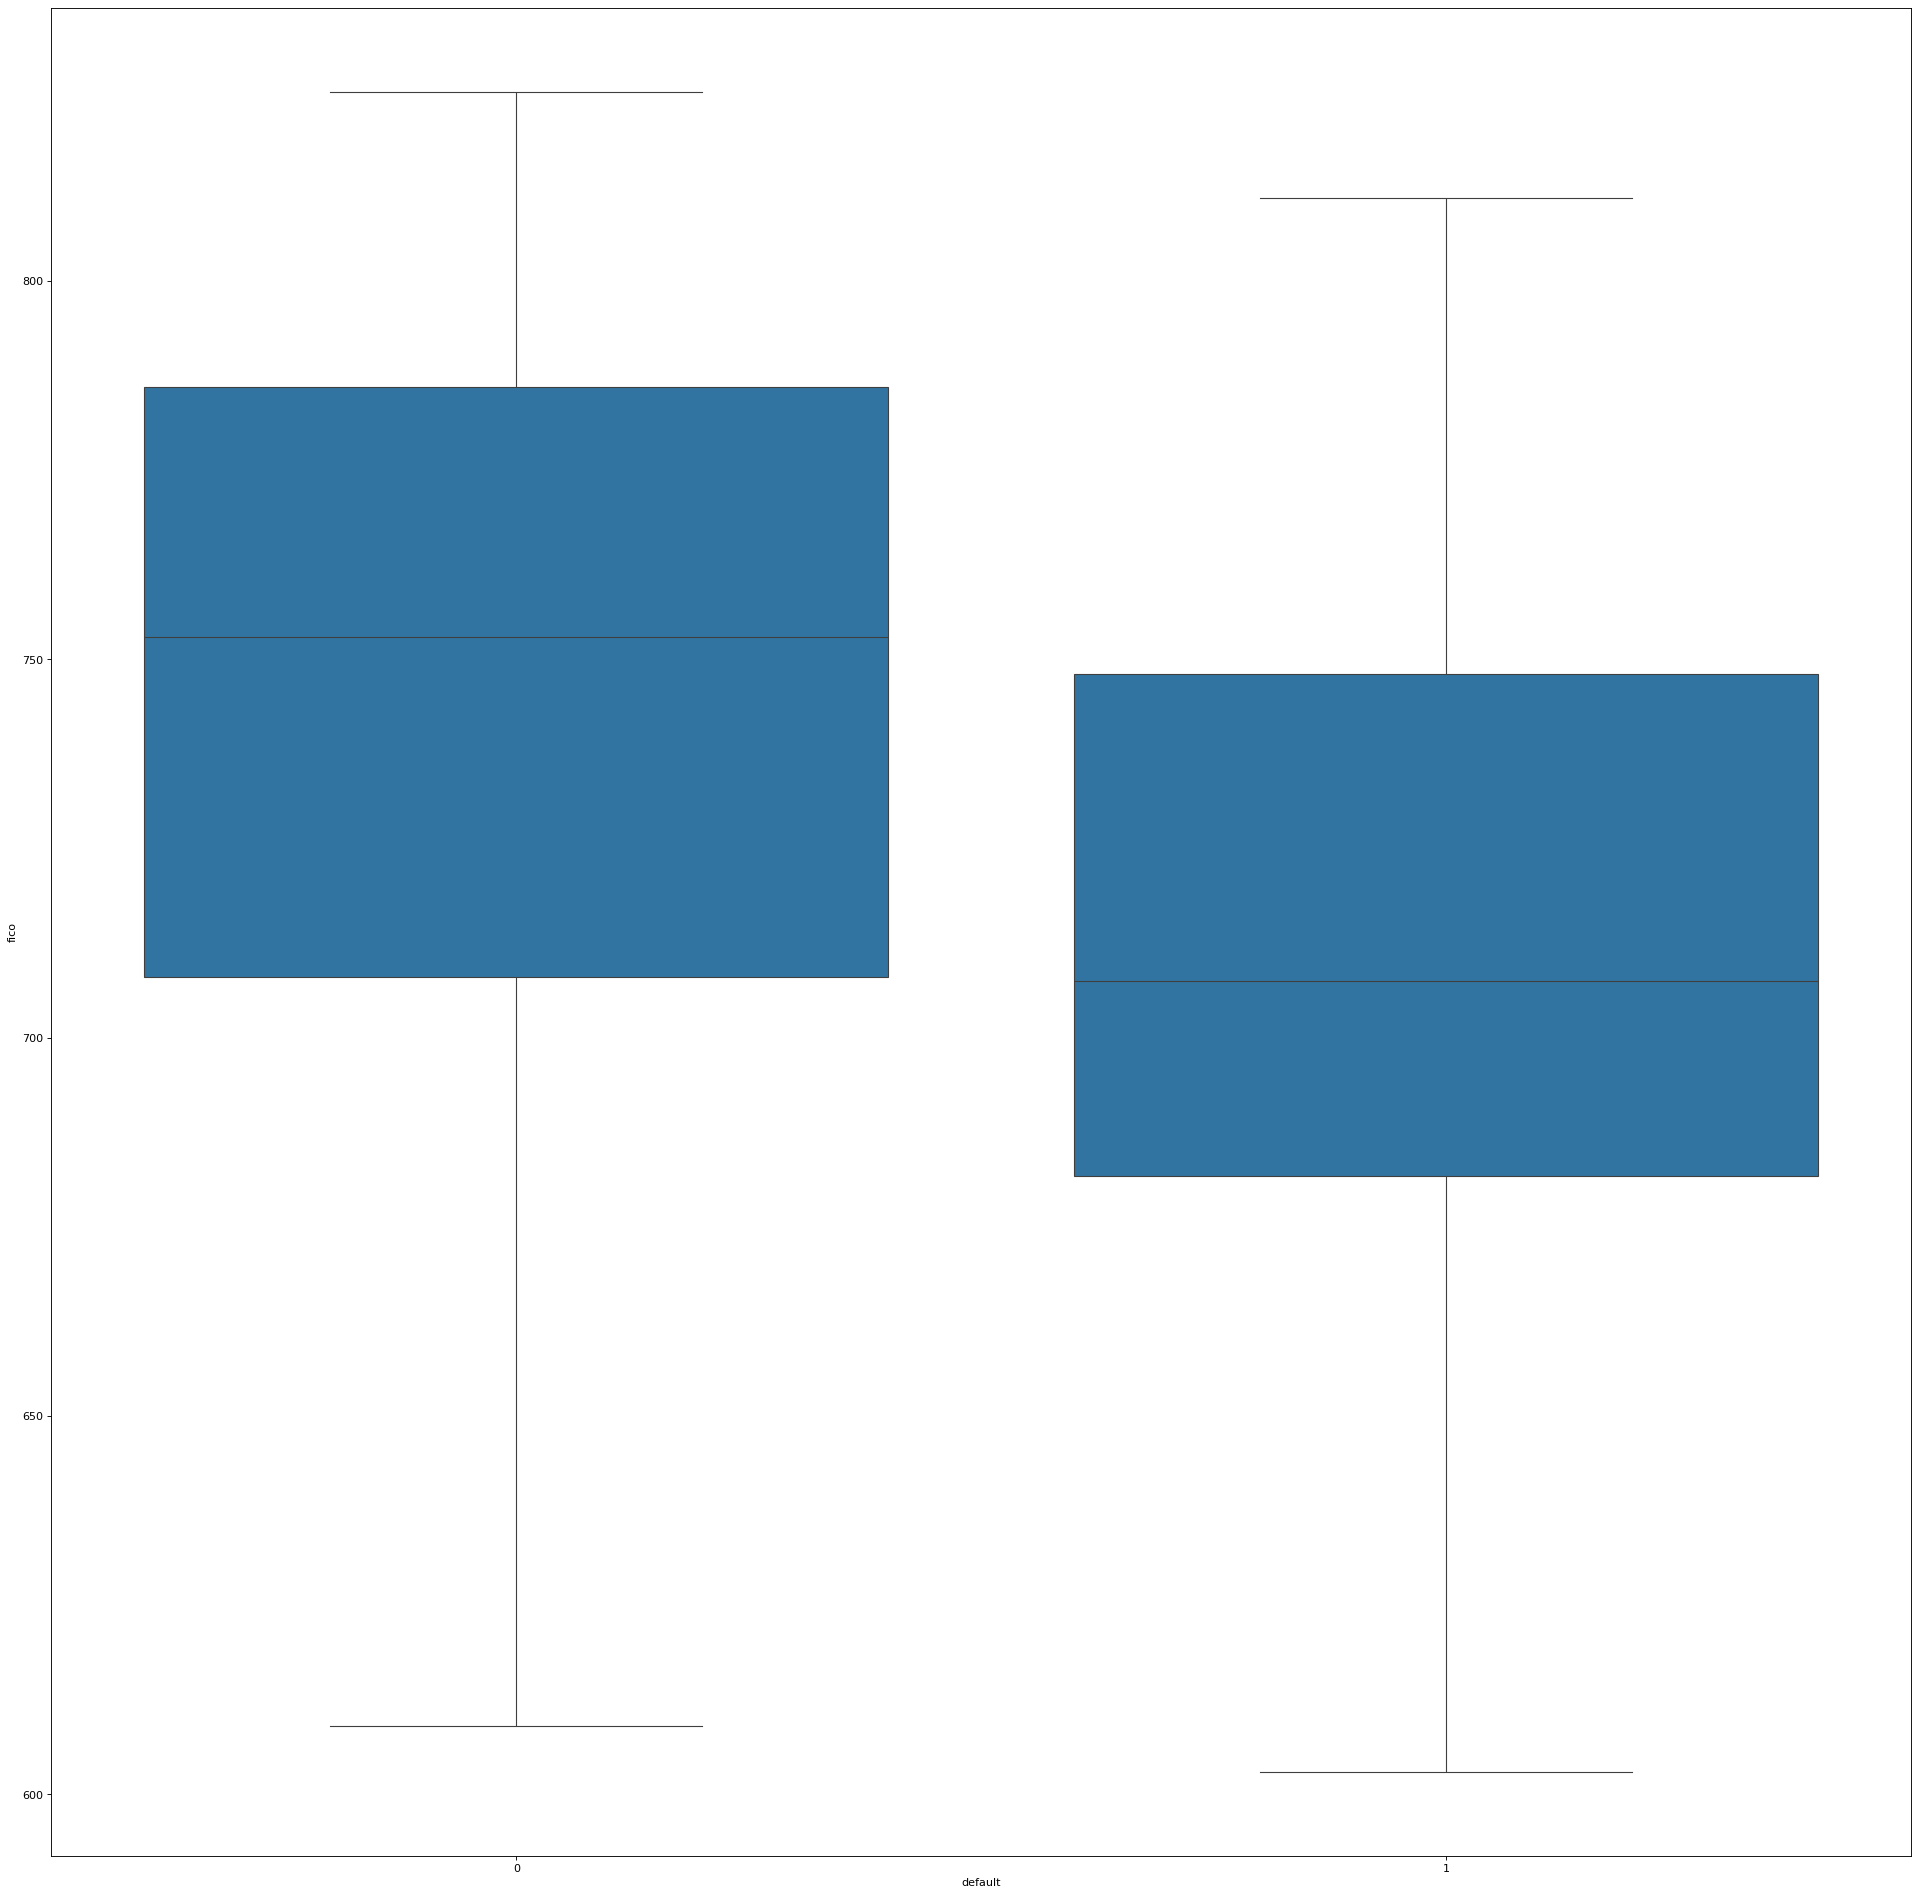

In [21]:
sns.boxplot(df_train, x = "default", y = "fico")

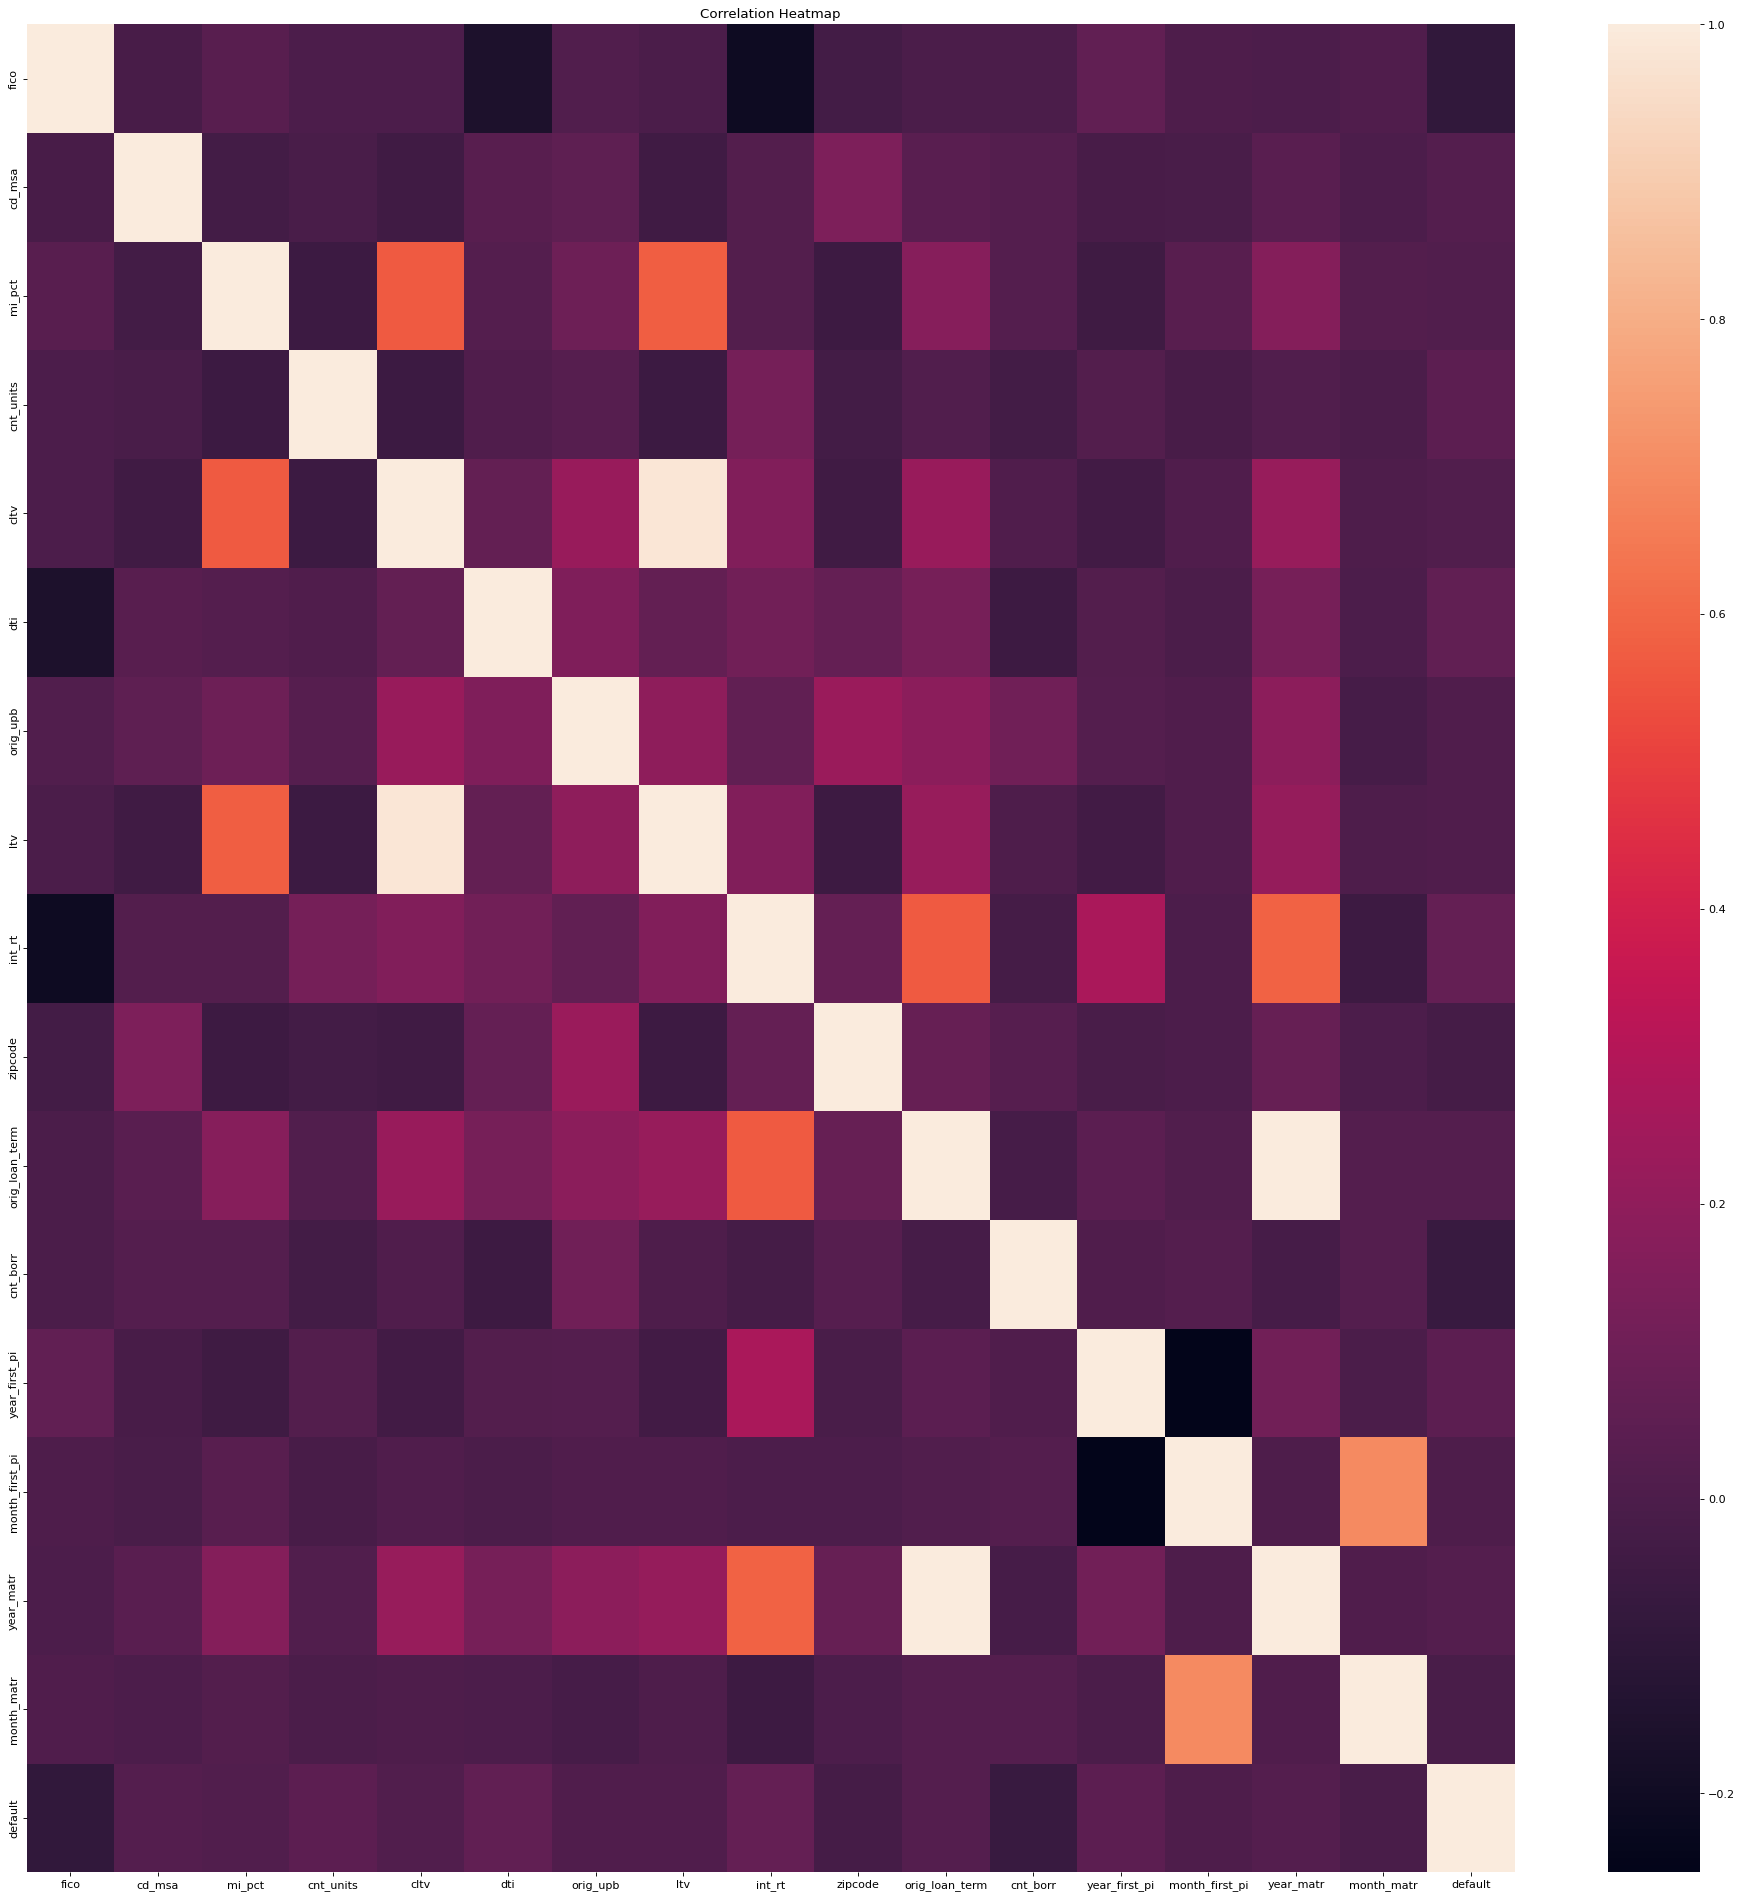

In [22]:
ax = plt.axes()
sns.heatmap(df_train.corr(numeric_only=True), ax = ax)

ax.set_title('Correlation Heatmap')
plt.show()

In [23]:
df_train.corr(numeric_only=True)["default"].sort_values()

fico             -0.088924
cnt_borr         -0.067223
zipcode          -0.026449
month_matr       -0.011260
month_first_pi    0.001582
ltv               0.008987
orig_upb          0.009113
cltv              0.010968
mi_pct            0.015046
orig_loan_term    0.020874
cd_msa            0.022357
year_matr         0.025028
cnt_units         0.046671
year_first_pi     0.046692
dti               0.062496
int_rt            0.069876
default           1.000000
Name: default, dtype: float64

In [24]:
df_train.corr(numeric_only=True,method = "kendall")["default"].sort_values()

fico             -0.070259
cnt_borr         -0.067223
zipcode          -0.019570
month_matr       -0.007160
month_first_pi    0.002512
ltv               0.004086
orig_upb          0.005456
cltv              0.006450
mi_pct            0.016643
cd_msa            0.018589
orig_loan_term    0.020838
year_first_pi     0.046692
year_matr         0.049422
cnt_units         0.052189
int_rt            0.054085
dti               0.054342
default           1.000000
Name: default, dtype: float64

In [25]:
df_train.corr(numeric_only=True,method = "spearman")["default"].sort_values()

fico             -0.085773
cnt_borr         -0.067223
zipcode          -0.023913
month_matr       -0.008375
month_first_pi    0.002939
ltv               0.004829
orig_upb          0.006670
cltv              0.007624
mi_pct            0.017139
orig_loan_term    0.021252
cd_msa            0.022634
year_first_pi     0.046692
cnt_units         0.052315
year_matr         0.052528
int_rt            0.064174
dti               0.065486
default           1.000000
Name: default, dtype: float64

In [26]:
df_train

,fico,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,...,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,year_first_pi,month_first_pi,year_matr,month_matr,default
4912,788.0,41940.0,0,1,P,26.0,31.0,409000,26.0,4.625,...,360,2,"STEARNSLENDING,LLC",FREEDOMMTGECORP,N,2018,4,2048,3,0
169,744.0,30020.0,0,1,I,75.0,42.0,79000,75.0,4.750,...,360,1,Other sellers,Other servicers,N,2017,3,2047,2,0
1048,641.0,12060.0,0,1,P,46.0,30.0,137000,46.0,4.750,...,360,1,"LOANDEPOTCOM,LLC",Other servicers,N,2017,5,2047,4,0
3350,706.0,19740.0,0,1,P,80.0,44.0,312000,80.0,4.375,...,360,2,"LOANDEPOTCOM,LLC","JPMORGANCHASEBANK,NA",N,2017,10,2047,9,0
2349,675.0,35614.0,0,1,P,49.0,44.0,319000,49.0,4.375,...,360,1,QUICKENLOANINC,QUICKENLOANINC,N,2017,6,2047,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5269,765.0,42644.0,0,1,I,75.0,24.0,374000,75.0,4.875,...,360,1,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",N,2018,6,2048,5,0
2498,794.0,11540.0,0,1,P,80.0,36.0,214000,80.0,4.125,...,360,2,"FLAGSTARBANK,FSB",MATRIXFINANCIALSERVI,N,2017,7,2047,6,0
3650,749.0,36260.0,30,1,P,95.0,34.0,295000,95.0,4.250,...,360,2,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,N,2017,10,2047,9,0
3653,798.0,19740.0,0,1,P,74.0,24.0,264000,74.0,3.875,...,360,1,QUICKENLOANINC,QUICKENLOANINC,N,2017,11,2047,10,0


In [27]:
df_train.columns

Index(['fico', 'cd_msa', 'mi_pct', 'cnt_units', 'occpy_sts', 'cltv', 'dti',
       'orig_upb', 'ltv', 'int_rt', 'channel', 'st', 'prop_type', 'zipcode',
       'loan_purpose', 'orig_loan_term', 'cnt_borr', 'seller_name',
       'servicer_name', 'flag_sc', 'year_first_pi', 'month_first_pi',
       'year_matr', 'month_matr', 'default'],
      dtype='object')

In [28]:
df_train['default'].value_counts()

default
0    4335
1      70
Name: count, dtype: int64

In [29]:
#convert X_train to a matrix
#X_train = X_train.values

In [30]:
#Oversample the train set, leave the test/valid sets as they are
oversample = RandomOverSampler(sampling_strategy='minority')
X_otrain, y_otrain = oversample.fit_resample(X_train, y_train)

In [31]:
#Undersample the train set, leave the test/valid sets as they are
undersample = RandomUnderSampler(sampling_strategy='majority')
X_utrain, y_utrain = undersample.fit_resample(X_train, y_train)

In [32]:
y_utrain.value_counts()

default
0    70
1    70
Name: count, dtype: int64

In [33]:
y_train.value_counts()

default
0    4335
1      70
Name: count, dtype: int64

# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
preprocessor = ColumnTransformer(
transformers=[
('cat', OneHotEncoder(handle_unknown='ignore'),
[4,10,11,12,13,14,17,18,19,20,21,22,23]),
],
remainder='passthrough'
)

In [36]:
boost = xgboost.XGBClassifier(n_estimators=100,tree_method="hist",
                              random_state=0,booster = 'gbtree')

In [37]:
m = make_pipeline(
preprocessor,
boost
).fit(X_utrain, y_utrain)

In [38]:
X_test

,fico,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,...,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,year_first_pi,month_first_pi,year_matr,month_matr
5826,781.0,12620.0,0,1,I,80.0,21.0,48000,80.0,5.875,...,P,360,1,Other sellers,Other servicers,N,2018,9,2048,8
2255,725.0,35084.0,0,2,I,75.0,31.0,176000,75.0,4.875,...,P,360,2,Other sellers,ROUNDPOINTMTGESERVIC,N,2017,7,2047,6
4166,764.0,22744.0,0,1,I,80.0,31.0,294000,80.0,4.250,...,P,180,2,Other sellers,Other servicers,N,2017,12,2032,11
2427,807.0,41940.0,0,1,P,36.0,25.0,350000,36.0,4.250,...,C,180,2,"LOANDEPOTCOM,LLC",Other servicers,N,2017,8,2032,7
3093,658.0,12060.0,25,1,P,90.0,43.0,167000,90.0,4.875,...,P,360,1,QUICKENLOANINC,QUICKENLOANINC,N,2017,9,2047,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854,713.0,47894.0,30,1,P,95.0,43.0,152000,95.0,4.875,...,P,360,2,Other sellers,Other servicers,N,2017,11,2047,10
1968,796.0,12580.0,0,1,P,30.0,20.0,108000,30.0,3.625,...,C,180,2,Other sellers,PINGORALOANSERVICING,N,2017,6,2032,5
1730,663.0,26900.0,0,1,P,90.0,34.0,400000,80.0,4.875,...,P,360,2,Other sellers,Other servicers,N,2017,7,2047,6
6091,813.0,34980.0,30,1,P,95.0,39.0,346000,95.0,4.750,...,P,360,2,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,N,2018,11,2048,10


In [39]:
y_hat = m.predict(X_test)

In [40]:
X_utrain

,fico,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,...,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,year_first_pi,month_first_pi,year_matr,month_matr
1932,753.0,40140.0,0,1,P,78.0,49.0,372000,78.0,4.125,...,P,360,1,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,N,2017,6,2047,5
3452,758.0,26620.0,25,1,P,90.0,20.0,74000,90.0,4.000,...,P,360,1,BRANCHBANKING&TRUSTC,BRANCHBANKINGANDTRUS,N,2017,10,2047,9
525,776.0,19740.0,0,1,P,48.0,48.0,275000,48.0,4.500,...,C,360,1,NATIONSTARMTGELLC,NATIONSTARMTGELLCDBA,N,2017,4,2047,3
2621,740.0,35004.0,0,1,P,57.0,48.0,322000,57.0,3.990,...,C,240,2,QUICKENLOANINC,QUICKENLOANINC,N,2017,8,2037,7
4122,715.0,47894.0,0,1,P,55.0,33.0,379000,55.0,4.250,...,C,360,2,NATIONSTARMTGELLCDBA,NEWRESIDENTIALMTGELL,N,2017,12,2047,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,754.0,39100.0,0,1,I,75.0,24.0,296000,75.0,5.125,...,C,360,1,Other sellers,MATRIXFINANCIALSERVI,N,2018,4,2048,3
4184,686.0,41700.0,0,1,P,80.0,31.0,416000,80.0,4.375,...,P,360,2,Other sellers,Other servicers,N,2017,12,2047,11
4148,748.0,34900.0,0,1,P,59.0,46.0,421000,59.0,4.125,...,C,360,1,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",N,2017,12,2047,11
3696,701.0,34820.0,12,1,S,85.0,40.0,115000,85.0,4.000,...,P,360,1,Other sellers,Other servicers,N,2017,11,2047,10


In [41]:
X_test

,fico,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,orig_upb,ltv,int_rt,...,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,year_first_pi,month_first_pi,year_matr,month_matr
5826,781.0,12620.0,0,1,I,80.0,21.0,48000,80.0,5.875,...,P,360,1,Other sellers,Other servicers,N,2018,9,2048,8
2255,725.0,35084.0,0,2,I,75.0,31.0,176000,75.0,4.875,...,P,360,2,Other sellers,ROUNDPOINTMTGESERVIC,N,2017,7,2047,6
4166,764.0,22744.0,0,1,I,80.0,31.0,294000,80.0,4.250,...,P,180,2,Other sellers,Other servicers,N,2017,12,2032,11
2427,807.0,41940.0,0,1,P,36.0,25.0,350000,36.0,4.250,...,C,180,2,"LOANDEPOTCOM,LLC",Other servicers,N,2017,8,2032,7
3093,658.0,12060.0,25,1,P,90.0,43.0,167000,90.0,4.875,...,P,360,1,QUICKENLOANINC,QUICKENLOANINC,N,2017,9,2047,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3854,713.0,47894.0,30,1,P,95.0,43.0,152000,95.0,4.875,...,P,360,2,Other sellers,Other servicers,N,2017,11,2047,10
1968,796.0,12580.0,0,1,P,30.0,20.0,108000,30.0,3.625,...,C,180,2,Other sellers,PINGORALOANSERVICING,N,2017,6,2032,5
1730,663.0,26900.0,0,1,P,90.0,34.0,400000,80.0,4.875,...,P,360,2,Other sellers,Other servicers,N,2017,7,2047,6
6091,813.0,34980.0,30,1,P,95.0,39.0,346000,95.0,4.750,...,P,360,2,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,N,2018,11,2048,10


In [42]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [43]:
confmat = confusion_matrix(y_true = y_test, y_pred=y_hat)

NameError: name 'warnings' is not defined

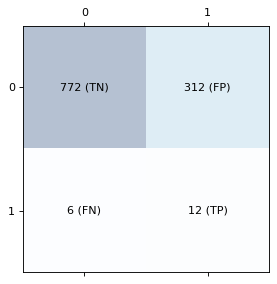

In [44]:
pretty_confusion_matrix(confmat, "", "",  labeling = True)


In [45]:
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

In [ ]:
print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

False Positive Rate (FPR): 0.321
Recall: 0.667
Precision: 0.033
F1 Score: 0.063


In [46]:
from xgboost import plot_tree

In [47]:
import graphviz 

In [ ]:
!pip install graphviz 

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.1 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 784.8 kB/s eta 0:00:00


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

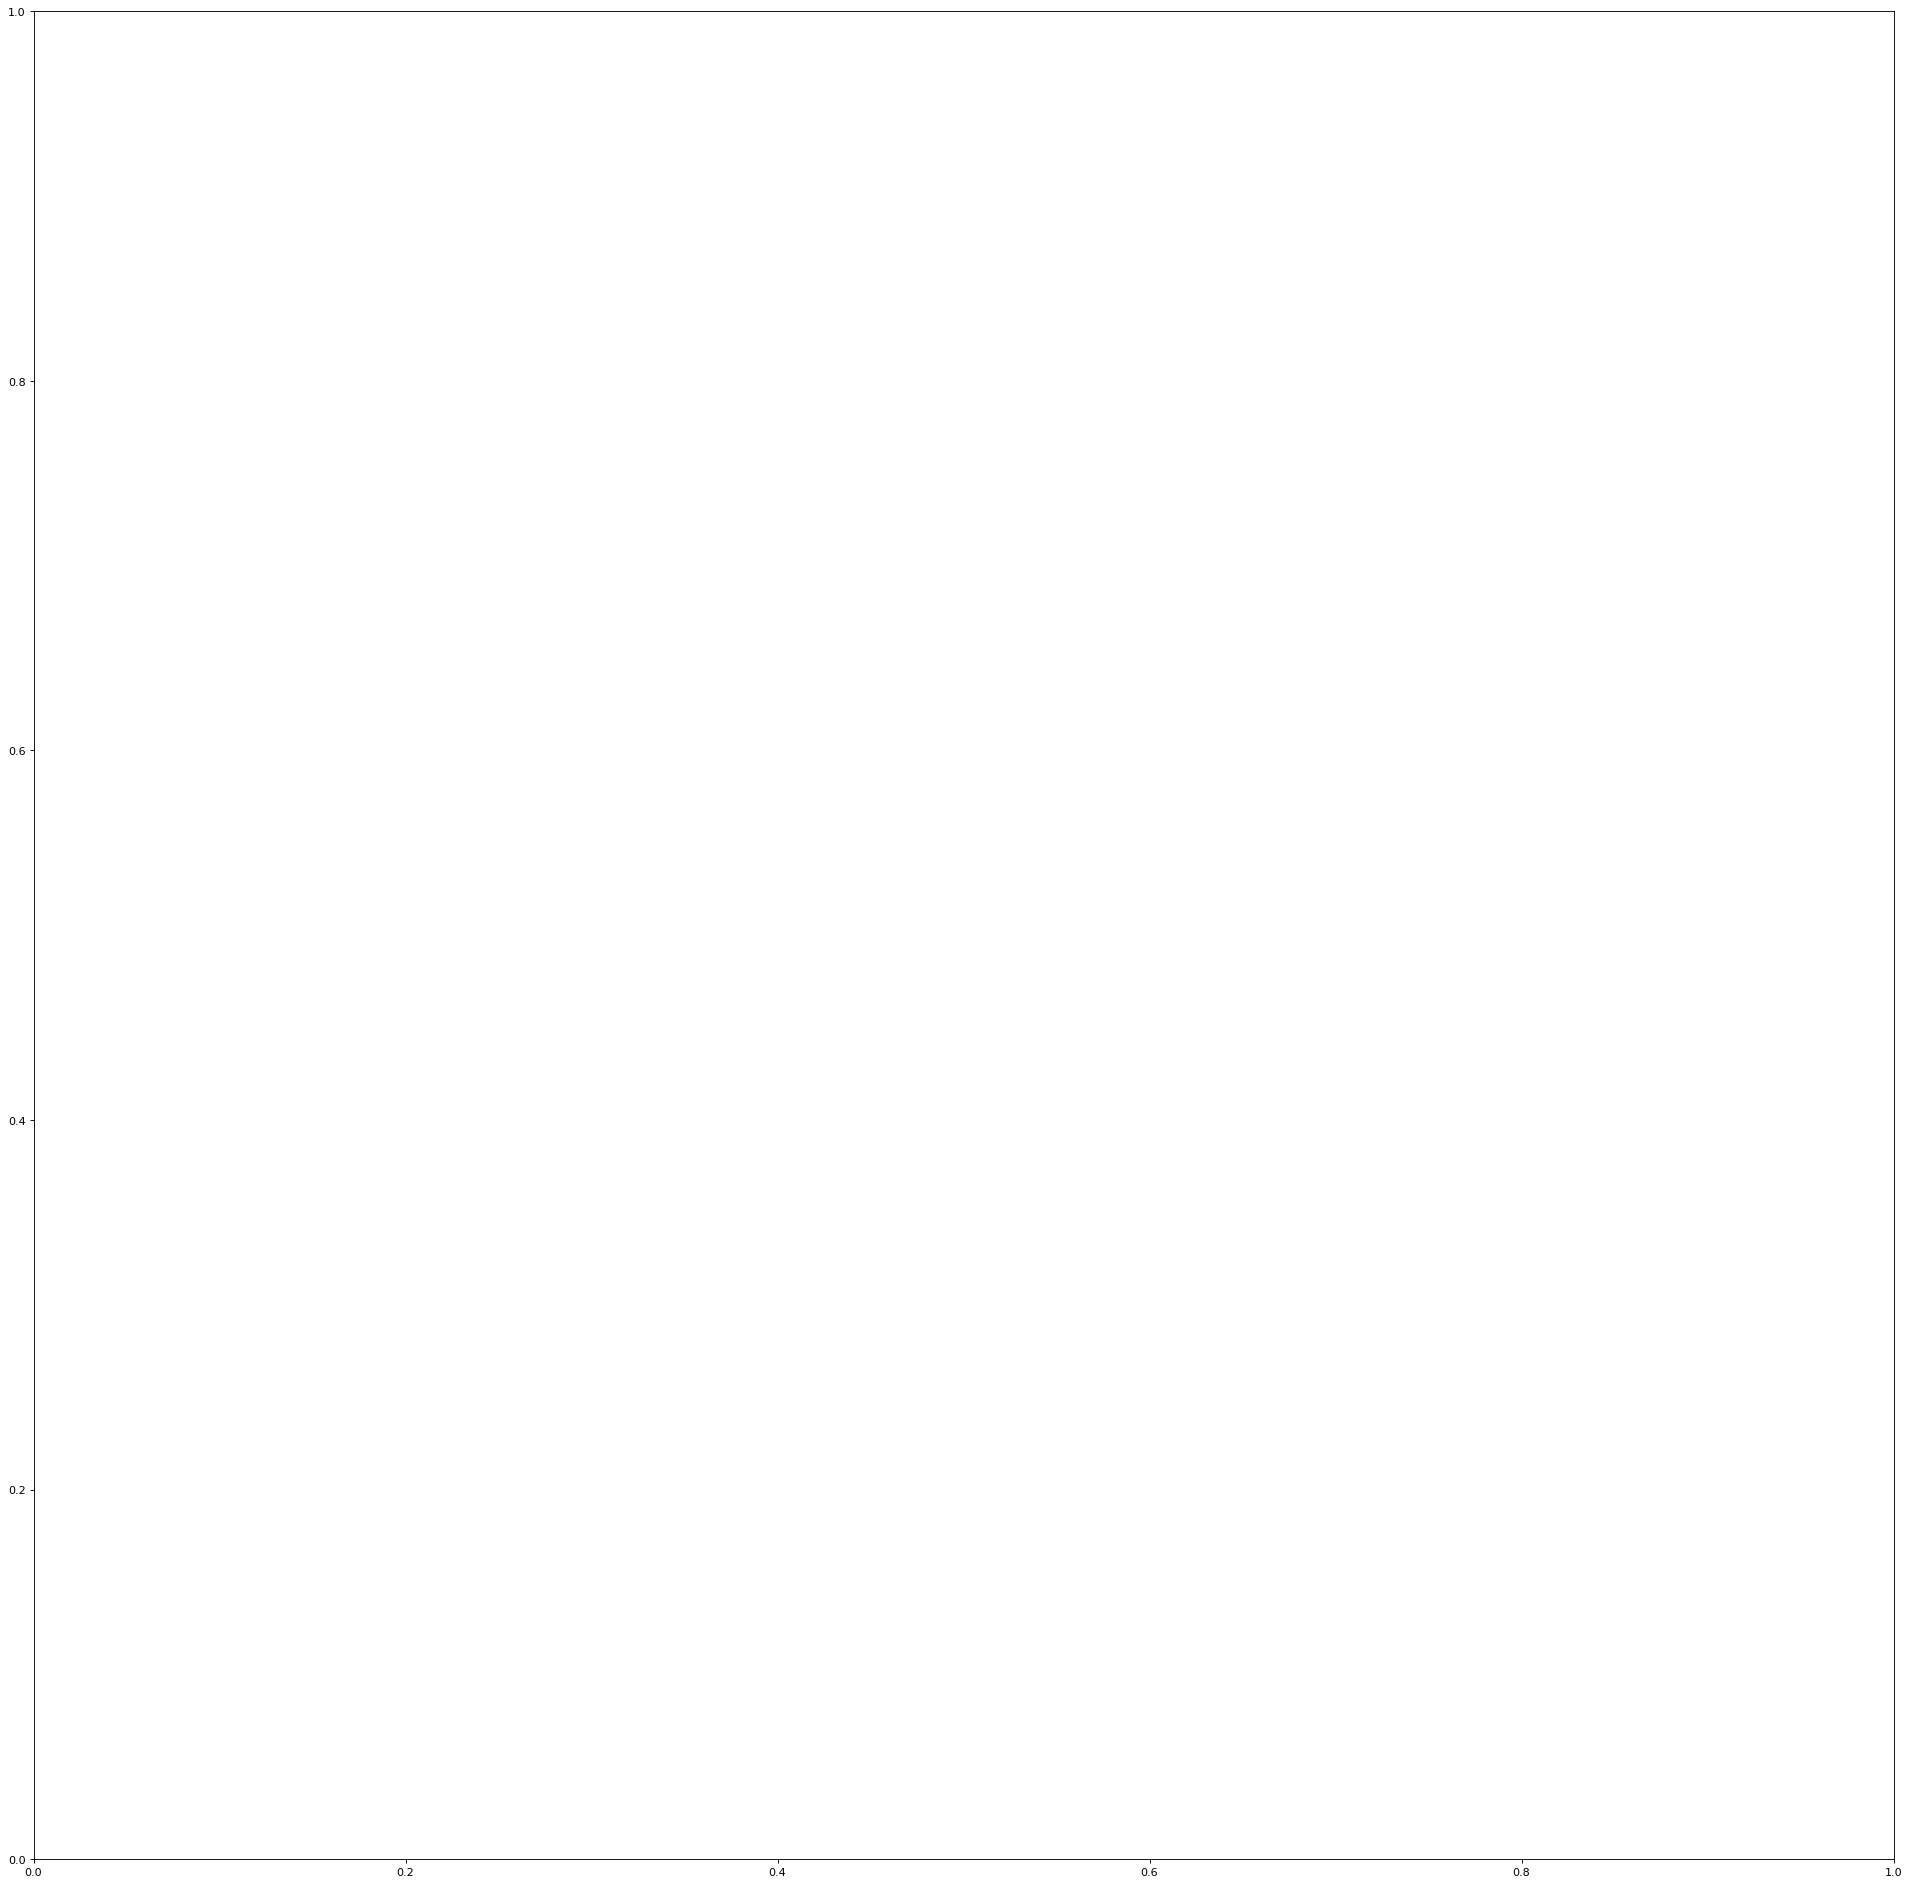

In [48]:
plot_tree(m[1])

In [242]:


#names = lasso.named_steps['preprocessor'].get_feature_names_out()

coef = pd.DataFrame(sorted(dict(zip(m[0].get_feature_names_out(),np.round(m[1].feature_importances_,4))).items(), key = lambda x:x[1], reverse=True),

                    columns = ["variable", "coefficient"])

print(coef.loc[coef['coefficient']!=0])

                                 variable  coefficient
0                              cat__st_FL       0.0824
1                          cat__flag_sc_N       0.0680
2          cat__seller_name_Other sellers       0.0647
3   cat__seller_name_CALIBERHOMELOANS,INC       0.0571
4                 cat__year_first_pi_2017       0.0558
5                       remainder__int_rt       0.0517
6                          remainder__dti       0.0497
7                   cat__month_first_pi_6       0.0484
8                       cat__prop_type_SF       0.0445
9      cat__servicer_name_Other servicers       0.0410
10                    cat__year_matr_2047       0.0370
11                    remainder__orig_upb       0.0362
12                      remainder__mi_pct       0.0336
13                      cat__prop_type_PU       0.0306
14                        remainder__fico       0.0301
15                        remainder__cltv       0.0267
16                    cat__year_matr_2048       0.0225
17        

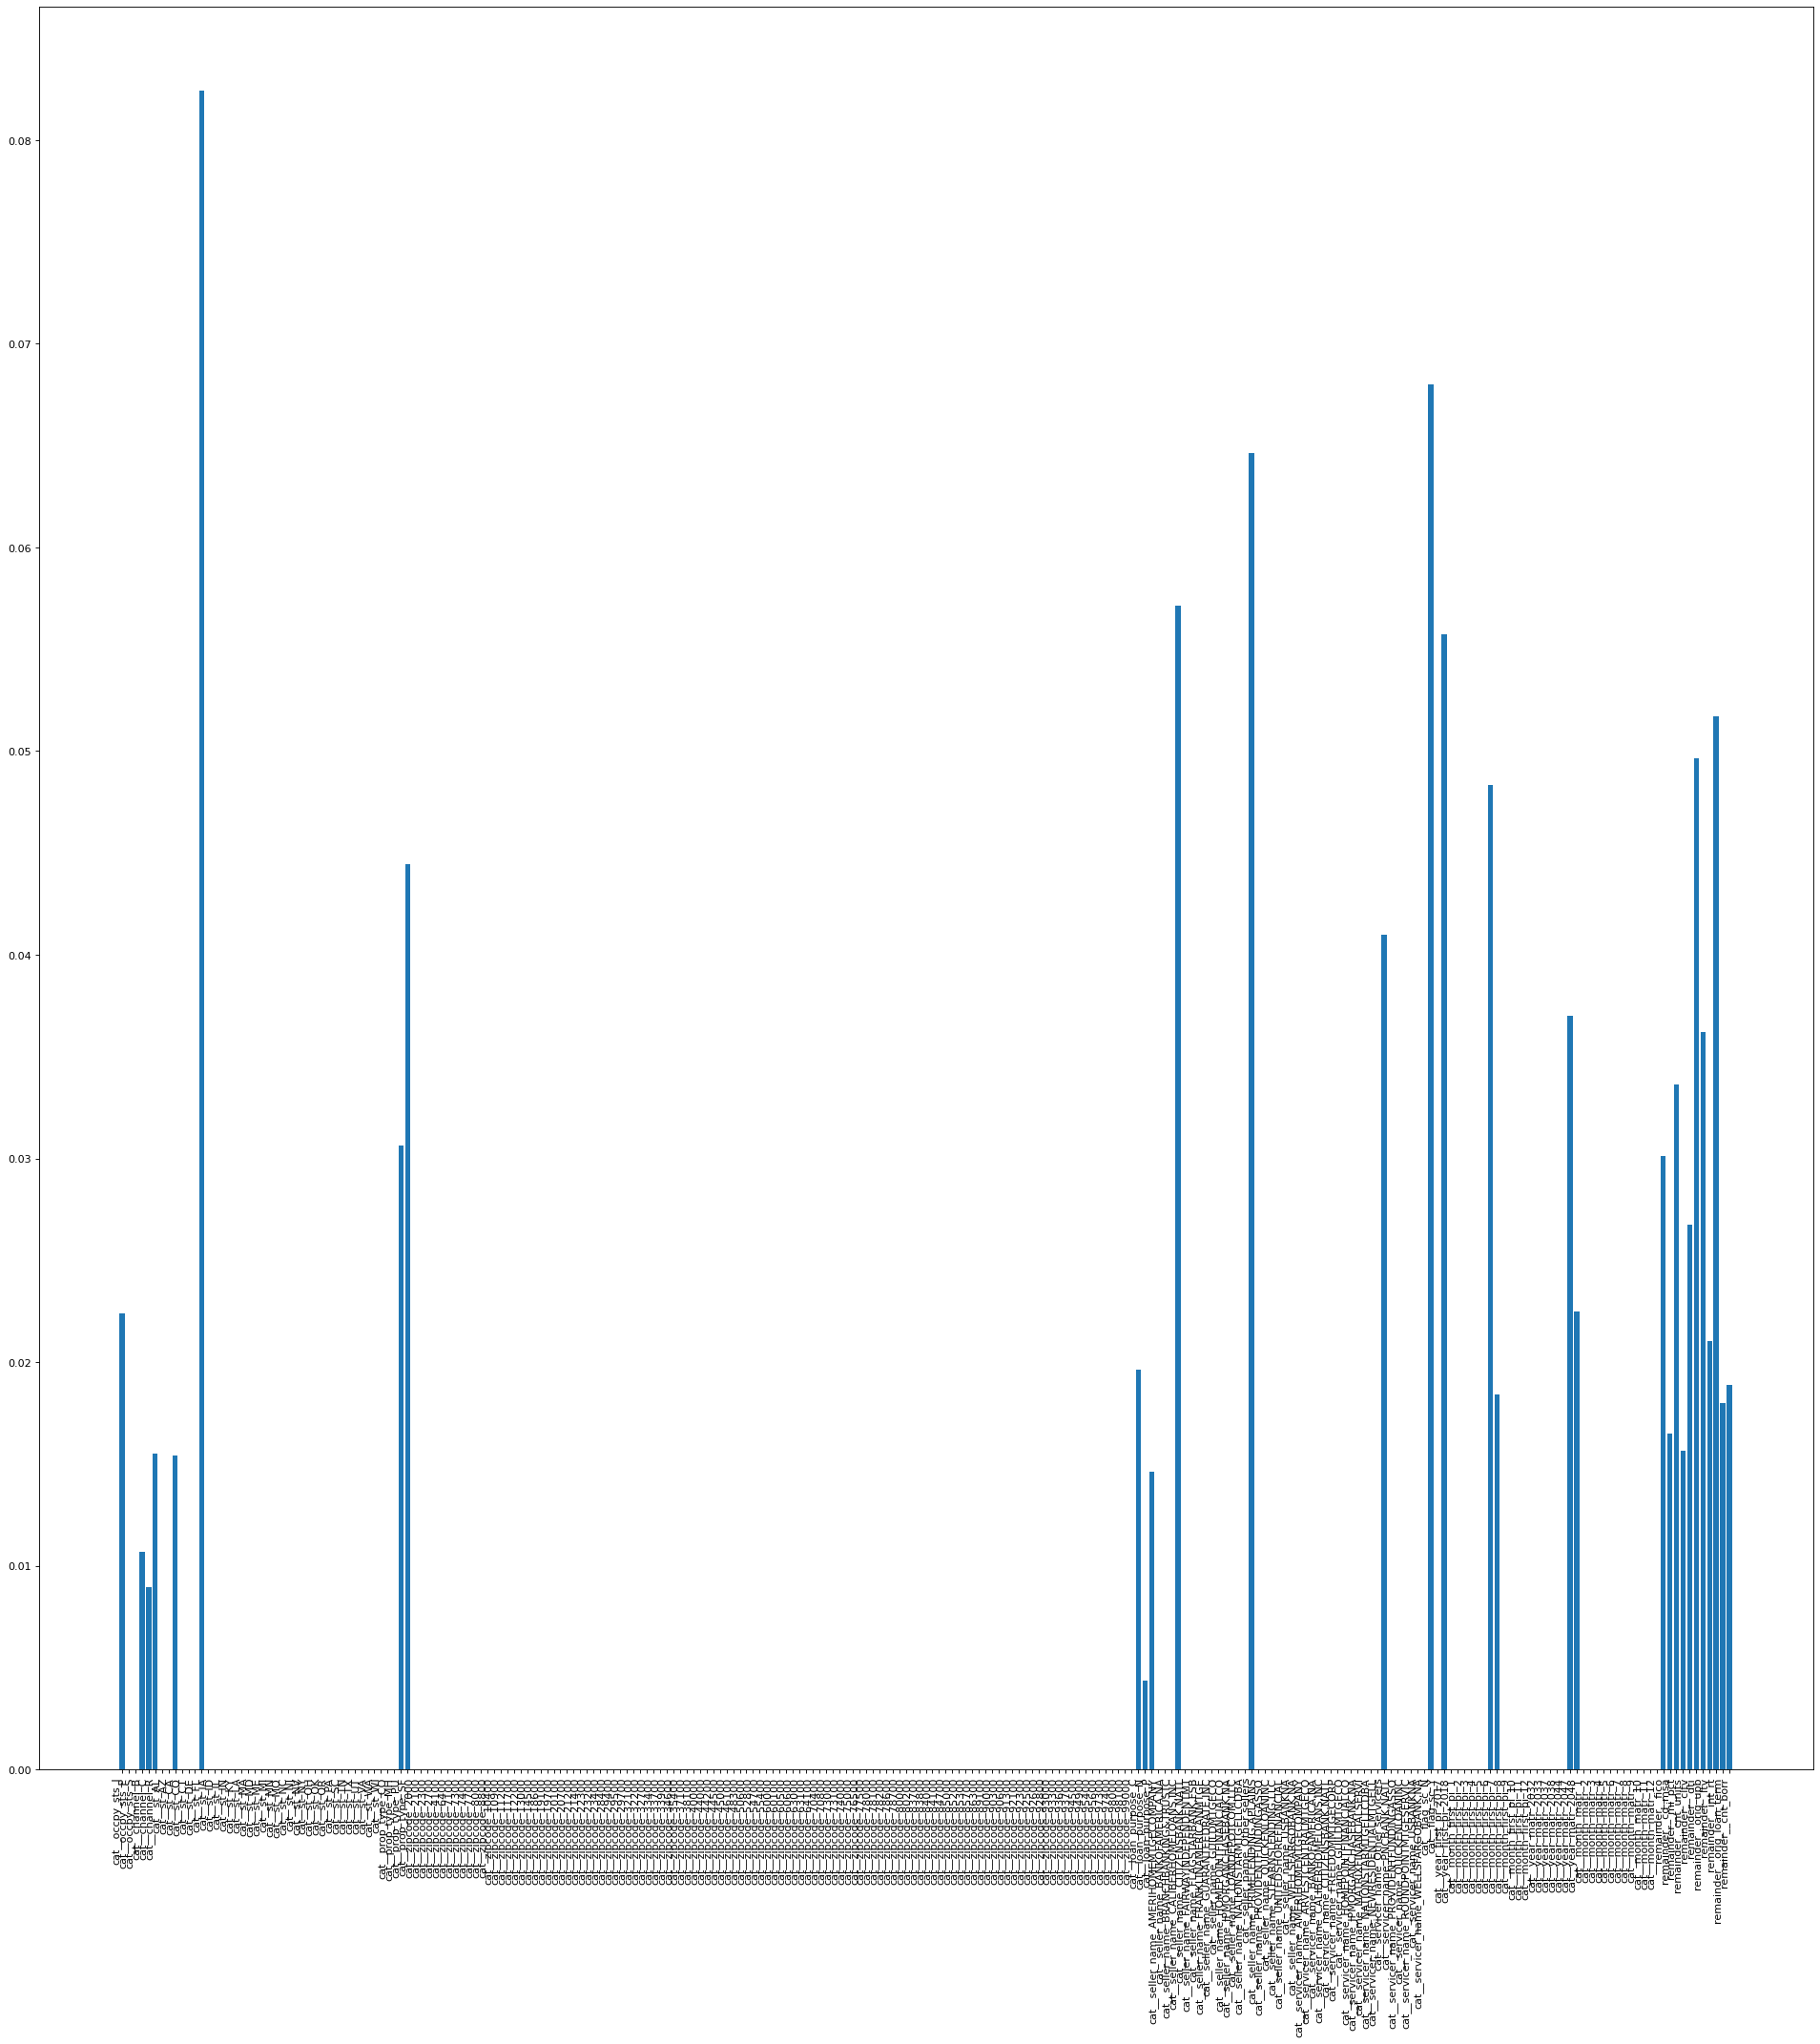

In [239]:
plt.bar(m[0].get_feature_names_out(), m[1].feature_importances_)
plt.xticks(rotation=90,ha='right')
plt.show()

In [228]:

#m[1].feature_importances_

array(['cat__occpy_sts_I', 'cat__occpy_sts_P', 'cat__occpy_sts_S',
       'cat__channel_B', 'cat__channel_C', 'cat__channel_R', 'cat__st_AL',
       'cat__st_AZ', 'cat__st_CA', 'cat__st_CO', 'cat__st_CT',
       'cat__st_DE', 'cat__st_FL', 'cat__st_IA', 'cat__st_ID',
       'cat__st_IL', 'cat__st_IN', 'cat__st_KY', 'cat__st_LA',
       'cat__st_MA', 'cat__st_MD', 'cat__st_ME', 'cat__st_MI',
       'cat__st_MN', 'cat__st_MO', 'cat__st_NC', 'cat__st_NJ',
       'cat__st_NV', 'cat__st_NY', 'cat__st_OH', 'cat__st_OK',
       'cat__st_OR', 'cat__st_PA', 'cat__st_SC', 'cat__st_TN',
       'cat__st_TX', 'cat__st_UT', 'cat__st_VA', 'cat__st_WA',
       'cat__st_WI', 'cat__prop_type_CO', 'cat__prop_type_MH',
       'cat__prop_type_PU', 'cat__prop_type_SF', 'cat__zipcode_2000',
       'cat__zipcode_2100', 'cat__zipcode_2300', 'cat__zipcode_2700',
       'cat__zipcode_4100', 'cat__zipcode_6400', 'cat__zipcode_7100',
       'cat__zipcode_7300', 'cat__zipcode_7400', 'cat__zipcode_7700',
       'cat

In [200]:
m2 = make_pipeline(
preprocessor,
boost
).fit(X_otrain, y_otrain)

In [201]:
y_hat2 = m2.predict(np.asarray(X_test))

In [202]:
confmat2 = confusion_matrix(y_true = y_test, y_pred=y_hat2)

NameError: name 'warnings' is not defined

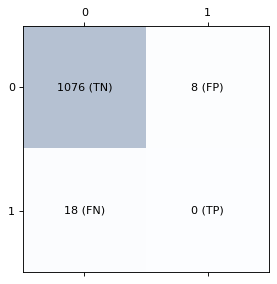

In [203]:
pretty_confusion_matrix(confmat2, "", "",  labeling = True)

In [205]:
FP = confmat2[0,1]
TN = confmat2[0,0]
TP = confmat2[1,1]
FN = confmat2[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

C:\Users\miste\AppData\Local\Temp\ipykernel_28828\3967240254.py:14: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2 * (Precision * Recall)/(Precision + Recall)


# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>